In [1]:
import camelot
import numpy as np
import glob
from pypdf import PdfReader, PdfWriter
import os
from typing import List,Dict,Tuple,Optional,Set
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import numpy as np
import folium
import random
import json
import folium.plugins
import pandas as pd


In [91]:
def datasheets_pdf_to_tables_pdf(input_dir: str,output_dir:str) -> List[str]:
    if not os.path.exists(input_dir):
        raise Exception(f"{input_dir} doesn't exist")
    
    os.makedirs(output_dir, exist_ok=True)
    
    pdf_files = glob.glob("*.pdf",root_dir=input_dir,recursive=True)

    if not pdf_files:
        raise Exception(f"No pdf files in {input_dir}")
    
    ingested_items = [] 
    for pdf_file in pdf_files:
        output_filename = f"{output_dir}/{pdf_file}"
        if os.path.exists(output_filename):
            continue
            
        input_file = f"{input_dir}/{pdf_file}"
        ingested_items.append(input_file)
        
        reader = PdfReader(input_file)
        writer = PdfWriter()
        # exports page 2
        writer.add_page(reader.pages[1])  
    
        with open(output_filename, "wb") as f:
            writer.write(f)
    return ingested_items

ret = datasheets_pdf_to_tables_pdf('datasheets_raw','datasheets2')
print(ret)

[]


In [102]:
def load_ingested_datasheets(input_dir: str)-> Dict[Tuple[str,str],Dict[str,List[float]]]:
    datasheets = {}
    pdf_files = glob.glob("*.pdf",root_dir=input_dir,recursive=True)
    
    for pdf_file in pdf_files:
        origin,dest = ".".join(pdf_file.split(".")[0:-1]).split("-")
        
        if (origin.lower(),dest.lower()) in datasheets.keys():
            continue
            
        tables = camelot.read_pdf(
            f"datasheets/{pdf_file}",
            pages="all",
            flavor="stream"   # best for non-grid tables
        )
        datasheets[(origin.lower(),dest.lower())] = {}
        datasheets[(origin.lower(),dest.lower())] = {'mobility_coeff':tables[0].df[2:10],
                                     'total_monthly_waiting_days': tables[0].df[11:19],
                                     'monthly_max_consecutive_waiting_periods_days': tables[0].df[20:28],
                                     'passage_duration_in_days': tables[0].df[30:37],
                                     'passage_vmg_knots': tables[0].df[39:45]
        }
    return datasheets

datasheets = load_ingested_datasheets('datasheets2')    


In [115]:
def generate_network_graph(datasheets: Dict[Tuple[str,str],object])->Dict[str,List[Tuple[str,Tuple[str,str]]]]:
    graph = defaultdict(list)
    
    for (origin, dest) in datasheets.keys():
        graph[origin.lower()].append((dest.lower(), (origin.lower(), dest.lower())))
    return graph

graph = generate_network_graph(datasheets)

In [116]:
def serialize_datasheets(datasheets: Dict[Tuple[str,str],object],output_filename:str)->None:
    with open(output_filename,"wb") as fd:
        pickle.dump(datasheets,fd)
def serialize_graph(graph: Dict[str,List[object]],output_filename:str)->None:
    with open(output_filename,"wb") as fd:
        pickle.dump(graph,fd)
serialize_datasheets(datasheets,"datasheets.pkl")
serialize_graph(graph,"graph.pkl")

In [2]:
def deserialize_datasheets(serialized_datasheets_path: str)-> Dict[Tuple[str,str],object]:
    datasheets = {}
    with open(serialized_datasheets_path,"rb") as fd:
        datasheets = pickle.load(fd)
    return datasheets
    
def deserialize_graph(serialized_graph_path: str)-> Dict[str,List[object]]:
    graph = {}
    with open(serialized_graph_path,"rb") as fd:
        graph = pickle.load(open("graph.pkl","rb"))
    return graph

datasheets = deserialize_datasheets("datasheets.pkl")
graph = deserialize_graph("graph.pkl")

In [3]:
print(len(graph.keys()))
print(len(datasheets.keys()))

225
777


In [7]:
def find_paths(graph: Dict[str,List[object]], start:str, max_hops: int, visited:Optional[Set[str]]=None, path:Optional[List[str]]=None):
    if visited is None:
        visited = set()
    if path is None:
        path = [start]

    # hop count = edges = len(path) - 1
    if len(path) - 1 >= max_hops:
        return []
    
    visited.add(start)
    results = []

    for next_node, route in graph.get(start, []):

        if next_node in visited:
            continue  # prevents cycles

        new_path = path + [next_node]

        # record this path
        results.append(new_path)
        
        # keep extending
        results.extend(
            find_paths(
                graph,
                next_node,
                max_hops,
                visited.copy(),
                new_path,
            )
        )

    return results

def calculate_all_routes_from_start_points(start_positions: List[str],graph:Dict[str,List[object]], max_hops: int = 5)->List[Dict[str,object]]:
    compound_routes = []
    
    # for origin in graph:
    for origin in start_positions:
        for path in find_paths(graph, origin, max_hops):
            compound_routes.append({
                "origin": path[0],
                "dest": path[-1],
                "path": path,
            })
    return compound_routes

start_points = ['tyre','carthage']
tyre_carthage_compund_routes = calculate_all_routes_from_start_points(start_points,graph, max_hops=5)

In [8]:
start = "tyre"
end = "carthage"
counter = 0
for res in tyre_carthage_compund_routes:
    if res['origin'] == start and res['dest'] == end:
        counter+= 1
print(f"Amount of routes that start with {start} and end with {end}",counter)

Amount of routes that start with tyre and end with carthage 378


In [9]:
print(f"Amount of total calculated available routes that start from {start_points} is : {len(tyre_carthage_compund_routes)}")


Amount of total calculated available routes that start from ['tyre', 'carthage'] is : 40291


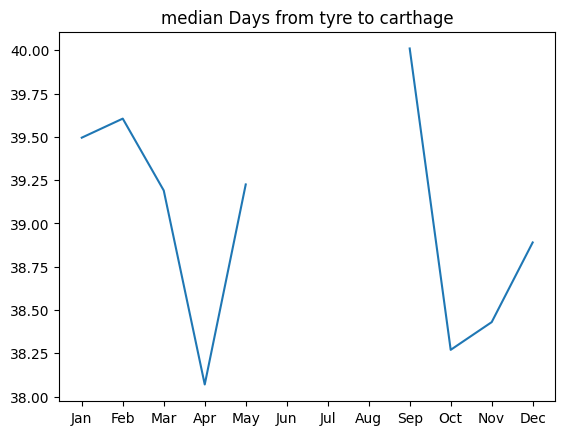

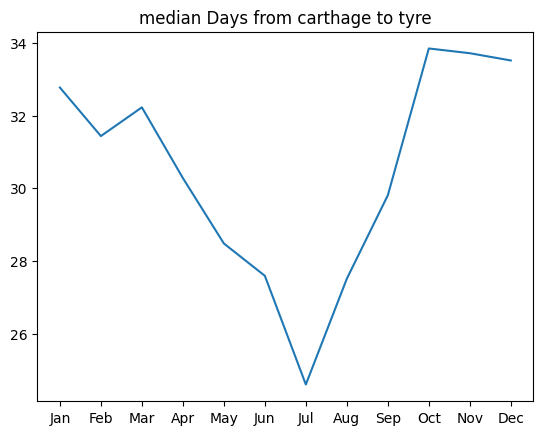

Shortest path from tyre to carthage in Jan is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'malta', 'carthage']} with 38.73
Shortest path from tyre to carthage in Feb is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'leptis_magna', 'carthage']} with 36.81
Shortest path from tyre to carthage in Mar is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'malta', 'carthage']} with 34.9
Shortest path from tyre to carthage in Apr is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'leptis_magna', 'carthage']} with 28.98
Shortest path from tyre to carthage in May is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'alexandria', 'apollonia', 'leptis_magna', 'carthage']} with 35.07
Shortest path from tyre to carthage in Sep is {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'alexandria', 'apollonia', 'leptis_magna', 'carthage']} with 40.010000000000005
Shortest path from tyre to carthage in Oct is {'origin':

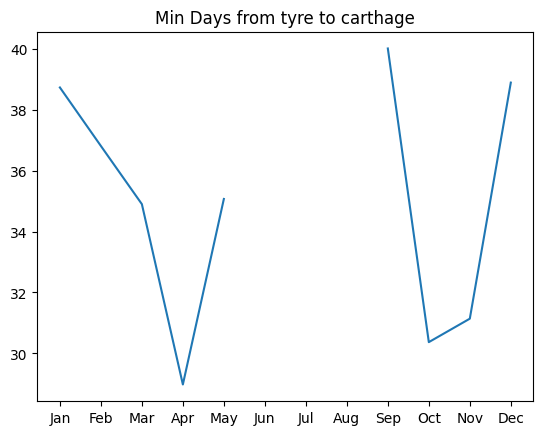

Shortest path from carthage to tyre in Jan is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 22.27
Shortest path from carthage to tyre in Feb is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 20.830000000000002
Shortest path from carthage to tyre in Mar is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 22.310000000000002
Shortest path from carthage to tyre in Apr is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 20.19
Shortest path from carthage to tyre in May is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 18.5
Shortest path from carthage to tyre in Jun is {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']} with 16.310000000000002
Shortest path from carthage to tyre in Jul is {'origin': 'carthage', 'dest': 'tyre', 'path':

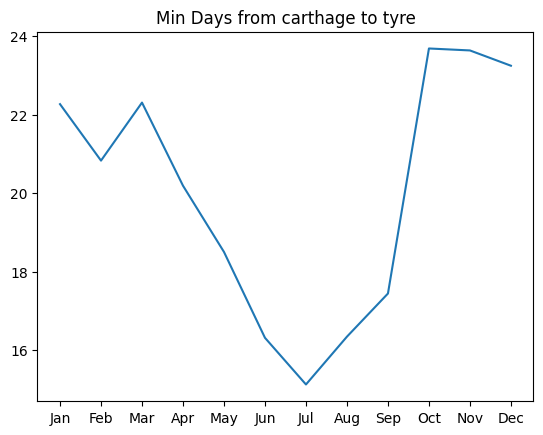

In [51]:
month_to_row = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
POSSIBLE_MOBILITY_COEFF = 0.2
MAX_VOYAGE_DAYS = 41
MAX_SEGMENT_SAILING_DAYS = 10
def random_hex_color():
    # Generate a random integer between 0 and 0xFFFFFF (inclusive)
    random_int = random.randint(0, 0xFFFFFF)
    # Format it as a 6-digit hex string, padding with leading zeros if necessary
    return f"#{random_int:06x}"

def generate_cities_to_latlon_dict():
    places = json.loads(open("places.json").read())
    cities_to_latlon = {}
    for place in places['features']:
        cities_to_latlon[place['properties']['name'].lower()] = (place['geometry']['coordinates'][::-1])
    return cities_to_latlon

def generate_valid_routes_per_month_bidirectional(start_points: List[str], compound_routes):
    global month_to_raw, POSSIBLE_MOBILITY_COEFF, MAX_VOYAGE_DAYS
    #Initialize struct
    valid_paths = {}
    for month in month_to_row.keys():
        valid_paths[month] = {'paths':[], 'days':[], 'waiting':[], 'sailing': []}

    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
            
            # Calculate
            for res in compound_routes:
                if res['origin'] == start and res['dest'] == end:
                    for month in valid_paths.keys():
                        valid = True # If it was possible using the mobility coeff
                        days = 0.0 # Total days for the voyage
                        sailing_time = 0 # Total days at sea
                        waiting_time = 0 # Total days waiting at port
                        
                        # Make sure for each segment that the path was possible using the mobility coeff in the datashets
                        for i in range(len(res['path'])-1):
                            if float(datasheets[(res['path'][i],res['path'][i+1])]['mobility_coeff'][month_to_row[month]][7]) < POSSIBLE_MOBILITY_COEFF:
                                valid = False
                                break
                            elif  float(datasheets[(res['path'][i],res['path'][i+1])]['passage_duration_in_days'][month_to_row[month]][34]) > MAX_SEGMENT_SAILING_DAYS:
                                valid = False
                                break
                            else:
                                # Add the amount of sailing days it took for the segment to the total amount of days
                                days += float(datasheets[(res['path'][i],res['path'][i+1])]['passage_duration_in_days'][month_to_row[month]][34])
                                # Add the helf of the median consecutive waiting period to the total amount of days
                                days += float(datasheets[(res['path'][i],res['path'][i+1])]['monthly_max_consecutive_waiting_periods_days'][month_to_row[month]][25])/2
                                
                                sailing_time += float(datasheets[(res['path'][i],res['path'][i+1])]['passage_duration_in_days'][month_to_row[month]][34])
                                
                                waiting_time += float(datasheets[(res['path'][i],res['path'][i+1])]['monthly_max_consecutive_waiting_periods_days'][month_to_row[month]][25])/2
                        
                        if valid and days < MAX_VOYAGE_DAYS:
                            valid_paths[month]['paths'].append(res)
                            valid_paths[month]['days'].append(days)
                            valid_paths[month]['waiting'].append(waiting_time)
                            valid_paths[month]['sailing'].append(sailing_time)
        
    return valid_paths


valid_paths = generate_valid_routes_per_month_bidirectional(start_points, tyre_carthage_compund_routes)

def filter_relevant_valid_paths(origin:str, dest: str, valid_paths):
    #Initialize struct
    relevant_valid_paths = {}
    for month in month_to_row.keys():
        relevant_valid_paths[month] = {'paths':[], 'days':[], 'waiting':[], 'sailing': []}

    for month in month_to_row.keys():
        for i, path in enumerate(valid_paths[month]['paths']):
            if path['origin'] == origin and path['dest'] == dest:
                relevant_valid_paths[month]['paths'].append(path)
                relevant_valid_paths[month]['days'].append(valid_paths[month]['days'][i])
                relevant_valid_paths[month]['waiting'].append(valid_paths[month]['waiting'][i])
                relevant_valid_paths[month]['sailing'].append(valid_paths[month]['sailing'][i])                
    
    return relevant_valid_paths

def genereate_median_total_days_per_month(start_points: List[str], valid_paths)->None:
    # Generate median sailing time for all valid paths with mobility over 0.2 and less than 40 days
    global month_to_row
    
    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)
            
            median_num_days = []
            for month in month_to_row.keys():
                if len(relevant_valid_paths[month]['days']) > 0:
                    median_num_days.append(np.median(relevant_valid_paths[month]['days']))
                else:
                    median_num_days.append(np.nan)
            plt.figure()
            plt.plot(month_to_row.keys(),median_num_days,label='median num days')
            plt.title(f"median Days from {start} to {end}")
            plt.show()

def genereate_min_total_days_per_month(start_points: List[str], valid_paths)->None:
    # Generate median sailing time for all valid paths with mobility over 0.2 and less than 40 days
    global month_to_row
    
    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)
            
            
            min_num_days = []
            for month in month_to_row.keys():
                if len(relevant_valid_paths[month]['days']) > 0:
                    idx = np.argmin(relevant_valid_paths[month]['days'])
                    path = relevant_valid_paths[month]['paths'][idx]
                    print(f"Shortest path from {start} to {end} in {month} is {path} with {relevant_valid_paths[month]['days'][idx]}")
                    min_num_days.append(relevant_valid_paths[month]['days'][idx])
                else :
                    min_num_days.append(np.nan)
            plt.figure()
            plt.plot(month_to_row.keys(),min_num_days,label='min num days')
            plt.title(f"Min Days from {start} to {end}")
            plt.show()

genereate_median_total_days_per_month(start_points, valid_paths)
genereate_min_total_days_per_month(start_points, valid_paths)

def generate_map_all_valid_paths_from_to_per_month(start_points: List[str], valid_paths, output_dir: str)->None:
    global month_to_row
    
    cities_to_latlon = generate_cities_to_latlon_dict()
    
    os.makedirs(output_dir,exist_ok = True)
    
    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)

            #Generate map of all valid paths from origin to dest 
            for month in month_to_row.keys():
                m = folium.Map(location=cities_to_latlon[start], zoom_start=4)
        
                if not len(relevant_valid_paths[month]['days']) > 0:
                   continue
                markers = set()
                for path in relevant_valid_paths[month]['paths']:
                    color = random_hex_color()
                    points = []
                    if start == relevant_valid_paths[month]['paths'][0]['origin']:
                        arrow  = '→' 
                    else:
                        arrow = '←'                    
                    # Generate Markers
                    points = []
                    for i,city in enumerate(path['path']):
                        points.append(cities_to_latlon[city])
                        folium.Marker(
                            location=cities_to_latlon[city],
                            icon=folium.DivIcon(
                                html=f"""
                                <div style="
                                    font-size: 12px;
                                    color: black;
                                    font-weight: bold;
                                    white-space: nowrap;
                                ">
                                    {city}
                                </div>
                                """
                            )
                        ).add_to(m)
                    
                    for i in range(len(path['path'])-1):
                        mobilty_coeff = float(datasheets[(path['path'][i],path['path'][i+1])]['mobility_coeff'][month_to_row[month]][7])
                        if  mobilty_coeff < 0.2:
                            arrow_color = 'red'
                        elif mobilty_coeff >= 0.2 and mobilty_coeff <= 0.4:
                            arrow_color = 'yellow'
                        else:
                            arrow_color = 'green'
                        pl = folium.PolyLine(
                            (points[i],points[i+1]),
                            color=color,
                            weight=4,
                        ).add_to(m)
                    
                        folium.plugins.PolyLineTextPath(
                            pl,
                            arrow,
                            repeat=True,
                            offset=7,
                            attributes={
                                "fill": arrow_color,          # ← text/arrow color
                                "font-weight": "bold",
                                "font-size": "14",
                            },
                        ).add_to(m)         
                    
                # Save the map to an HTML file
                m.save(os.path.join(output_dir,f"{month}_{start}_{end}_routes.html"))

generate_map_all_valid_paths_from_to_per_month(start_points, valid_paths, 'all_valid_paths_maps')


def generate_map_valid_shortest_paths_from_to_per_month(start_points: List[str], valid_paths, output_dir: str)->None:
    global month_to_row
    
    cities_to_latlon = generate_cities_to_latlon_dict()
    
    os.makedirs(output_dir,exist_ok = True)
    shortest_paths_data = {'month':[], 'path':[], 'sailing_time': [], 'waiting_time': []}
    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)

            #Generate maps of shorests optimal routes
            for month in month_to_row.keys():
                m = folium.Map(location=cities_to_latlon[start], zoom_start=5)
        
                if len(relevant_valid_paths[month]['days']) > 0:
        
                    idx = np.argmin(relevant_valid_paths[month]['days'])
                    path = relevant_valid_paths[month]['paths'][idx]
                    
                    shortest_paths_data['month'].append(month)
                    shortest_paths_data['path'].append(path)
                    shortest_paths_data['sailing_time'].append(relevant_valid_paths[month]['sailing'][idx])
                    shortest_paths_data['waiting_time'].append(relevant_valid_paths[month]['waiting'][idx])

                    if start == relevant_valid_paths[month]['paths'][0]['origin']:
                        arrow  = '→' 
                    else:
                        arrow = '←'
                    
                    color = 'black'
                    
                    # Generate Markers
                    points = []
                    for i,city in enumerate(path['path']):
                        points.append(cities_to_latlon[city])
                        folium.Marker(
                            location=cities_to_latlon[city],
                            icon=folium.DivIcon(
                                html=f"""
                                <div style="
                                    font-size: 12px;
                                    color: black;
                                    font-weight: bold;
                                    white-space: nowrap;
                                ">
                                    {city}
                                </div>
                                """
                            )
                        ).add_to(m)
                    
                    for i in range(len(path['path'])-1):
                        mobilty_coeff = float(datasheets[(path['path'][i],path['path'][i+1])]['mobility_coeff'][month_to_row[month]][7])
                        if  mobilty_coeff < 0.2:
                            arrow_color = 'red'
                        elif mobilty_coeff >= 0.2 and mobilty_coeff <= 0.4:
                            arrow_color = 'yellow'
                        else:
                            arrow_color = 'green'
                        pl = folium.PolyLine(
                            (points[i],points[i+1]),
                            color=color,
                            weight=4,
                        ).add_to(m)
                    
                        folium.plugins.PolyLineTextPath(
                            pl,
                            arrow,
                            repeat=True,
                            offset=7,
                            attributes={
                                "fill": arrow_color,          # ← text/arrow color
                                "font-weight": "bold",
                                "font-size": "14",
                            },
                        ).add_to(m)
        
                    m.save(os.path.join(output_dir,f"shortest_{month}_{start}_{end}_routes.html"))

generate_map_valid_shortest_paths_from_to_per_month(start_points, valid_paths, 'shortest_valid_paths_maps')

In [52]:
def generate_map_valid_shortest_paths_from_to_per_month(start_points: List[str], valid_paths, output_dir: str)->None:
    global month_to_row
    
    cities_to_latlon = generate_cities_to_latlon_dict()
    
    os.makedirs(output_dir,exist_ok = True)
    shortest_paths_data = {'month':[], 'path':[], 'sailing_time': [], 'waiting_time': []}

    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)

            #Generate maps of shorests optimal routes
            for month in month_to_row.keys():
                m = folium.Map(location=cities_to_latlon[start], zoom_start=5)
        
                if len(relevant_valid_paths[month]['days']) > 0:
        
                    idx = np.argmin(relevant_valid_paths[month]['days'])
                    path = relevant_valid_paths[month]['paths'][idx]
                    
                    shortest_paths_data['month'].append(month)
                    shortest_paths_data['path'].append(path)
                    shortest_paths_data['sailing_time'].append(relevant_valid_paths[month]['sailing'][idx])
                    shortest_paths_data['waiting_time'].append(relevant_valid_paths[month]['waiting'][idx])

                    if start == relevant_valid_paths[month]['paths'][0]['origin']:
                        arrow  = '→' 
                    else:
                        arrow = '←'
                    
                    color = 'black'
                    
                    # Generate Markers
                    points = []
                    for i,city in enumerate(path['path']):
                        points.append(cities_to_latlon[city])
                        folium.Marker(
                            location=cities_to_latlon[city],
                            icon=folium.DivIcon(
                                html=f"""
                                <div style="
                                    font-size: 12px;
                                    color: black;
                                    font-weight: bold;
                                    white-space: nowrap;
                                ">
                                    {city}
                                </div>
                                """
                            )
                        ).add_to(m)
                    
                    for i in range(len(path['path'])-1):
                        mobilty_coeff = float(datasheets[(path['path'][i],path['path'][i+1])]['mobility_coeff'][month_to_row[month]][7])
                        if  mobilty_coeff < 0.2:
                            arrow_color = 'red'
                        elif mobilty_coeff >= 0.2 and mobilty_coeff <= 0.4:
                            arrow_color = 'yellow'
                        else:
                            arrow_color = 'green'
                        pl = folium.PolyLine(
                            (points[i],points[i+1]),
                            color=color,
                            weight=4,
                        ).add_to(m)
                    
                        folium.plugins.PolyLineTextPath(
                            pl,
                            arrow,
                            repeat=True,
                            offset=7,
                            attributes={
                                "fill": arrow_color,          # ← text/arrow color
                                "font-weight": "bold",
                                "font-size": "14",
                            },
                        ).add_to(m)
        
                    m.save(os.path.join(output_dir,f"shortest_{month}_{start}_{end}_routes.html"))


In [ ]:
import pandas as pd

data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
              'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
              'Oct', 'Nov', 'Dec'],
    'path': [
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'malta', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'leptis_magna', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'carthage']},
        
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre' ]},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre']},
        
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'malta', 'carthage']},
        {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kommos', 'malta', 'carthage']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']},
        {'origin': 'carthage', 'dest': 'tyre', 'path': ['carthage', 'malta', 'kommos', 'tyre']}
    ],
    'waiting_time': [20.0, 15.5, 7.5, 4.0, 2.5, 30, 30, 30,  5.0, 6.0, 12.0, 12.0,
                     8.5, 7.5, 8.5, 6.0, 4.0, 2.0, 1.5, 2.0, 3.0, 7.0, 7.5, 7.5],
    'sailing_time': [18.73, 21.31, 19.12, 19.7, 22.42,60,60,60, 23.36, 20.55, 19.14, 19.14,
                     13.77, 13.33, 13.81, 14.19, 14.5, 14.31, 13.62, 14.34,
                     14.44, 16.69, 16.14, 16.14]
}

rows = []

for m, p, w, s in zip(
    data['month'],
    data['path'],
    data['waiting_time'],
    data['sailing_time']
):
    rows.append({
        'month': m,
        'from': p['origin'],
        'to': p['dest'],
        'path': " → ".join(p['path']),
        'waiting_time': w,
        'sailing_time': s,
        'total_time': w + s
    })

df = pd.DataFrame(rows)

import seaborn as sns
import matplotlib.pyplot as plt

df['route_type'] = df['path'].astype('category')

plt.figure(figsize=(12,6))
sns.barplot(
    data=df,
    x='month',
    y='total_time',
    hue='route_type'
)
plt.title("Seasonal Routes and Total Travel Time")
plt.ylabel("Total Time (days)")
plt.show()



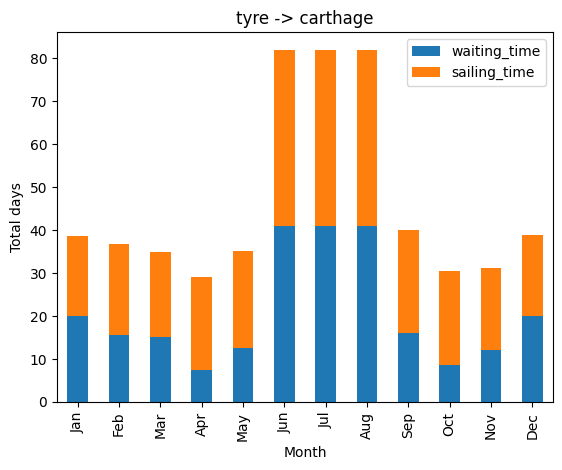

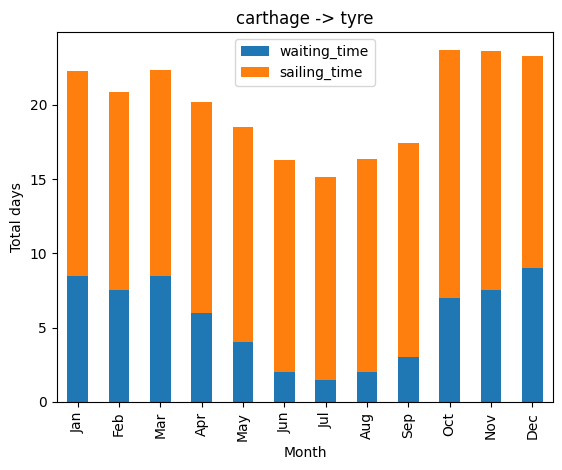

,month,origin,dest,path,waiting_time,sailing_time,total_time
1,Jan,tyre,carthage,"['tyre', 'kommos', 'malta', 'carthage']",20.0,18.7,38.7
6,Feb,tyre,carthage,"['tyre', 'kommos', 'leptis_magna', 'carthage']",15.5,21.3,36.8
29,Mar,tyre,carthage,"['tyre', 'kommos', 'malta', 'carthage']",15.0,19.9,34.9
92,Apr,tyre,carthage,"['tyre', 'kommos', 'leptis_magna', 'carthage']",7.5,21.5,29.0
126,May,tyre,carthage,"['tyre', 'alexandria', 'apollonia', 'leptis_magna', 'carthage']",12.5,22.6,35.1
132,Jun,tyre,carthage,,41.0,41.0,41.0
133,Jul,tyre,carthage,,41.0,41.0,41.0
134,Aug,tyre,carthage,,41.0,41.0,41.0
135,Sep,tyre,carthage,"['tyre', 'alexandria', 'apollonia', 'leptis_magna', 'carthage']",16.0,24.0,40.0
141,Oct,tyre,carthage,"['tyre', 'alexandria', 'apollonia', 'leptis_magna', 'carthage']",8.5,21.9,30.4


In [56]:

def generate_colored_table_view_valid_paths(start_points: List[str], valid_paths, max_per_month=0, requests_months:Optional[List[str]]=None, fill_unknown:bool=True):

    rows = []
    for start in start_points:
        for end in start_points:
            if start == end: 
                continue
                        
            relevant_valid_paths = filter_relevant_valid_paths(start, end, valid_paths)
                
            for month, data in relevant_valid_paths.items():
                if requests_months and month not in requests_months:
                    continue
                paths = data['paths']
                waiting = data['waiting']
                sailing = data['sailing']
                if fill_unknown and len(paths) == 0:
                    rows.append({
                        'month': month,
                        'origin': start,
                        'dest': end,
                        'path': '',
                        'waiting_time': MAX_VOYAGE_DAYS,
                        'sailing_time': MAX_VOYAGE_DAYS,
                        'total_time': MAX_VOYAGE_DAYS,
                    })
                    continue
                for p, w, s in zip(paths, waiting, sailing):
                    rows.append({
                        'month': month,
                        'origin': p['origin'],
                        'dest': p['dest'],
                        'path': p['path'],
                        'waiting_time': w,
                        'sailing_time': s,
                        'total_time': w + s
                    })
        
    df = pd.DataFrame(rows)    
    if max_per_month > 0:
        df = (
            df
            .sort_values('total_time')
            .groupby(['month','origin'], as_index=False)
            .head(max_per_month)
        )
    # define calendar order
    month_order = ['Jan','Feb','Mar','Apr','May','Jun',
                   'Jul','Aug','Sep','Oct','Nov','Dec']
    
    df['month'] = pd.Categorical(
        df['month'],
        categories=month_order,
        ordered=True
    )
    
    
    # sort
    df_sorted = df.sort_values(
        by=['origin','month','total_time'],
        ascending=[False, True, False]
    )
    
    # assume df already exists from previous step
    
    def direction_color(row):
        if row['origin'] == start_points[0]:
            return ['background-color: #e3f2fd'] * len(row)   # light blue
        else:
            return ['background-color: #fff3e0'] * len(row)   # light orange
    
    
    styled = (
        df_sorted
        .style
        # color by direction
        .apply(direction_color, axis=1)
        
        # gradient for total time
        .background_gradient(
            subset=['total_time'],
            cmap='RdYlGn_r'
        )
        
        # lighter gradients for components
        .background_gradient(
            subset=['waiting_time'],
            cmap='Blues'
        )
        .background_gradient(
            subset=['sailing_time'],
            cmap='Greens'
        )
        
        # formatting
        .format({
            'waiting_time': '{:.1f}',
            'sailing_time': '{:.1f}',
            'total_time': '{:.1f}'
        })
        
        # column styling
        .set_properties(
            subset=['path'],
            **{
                'font-family': 'monospace',
                'white-space': 'nowrap'
            }
        )
        
        # table styles
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#263238'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '6px'),
                ('border', '1px solid #ddd')
            ]},
        ])
    )

    ax = df_sorted[df_sorted['origin'] == start_points[0]][['waiting_time', 'sailing_time']].plot(kind='bar', stacked=True)
    ax.set_title(f"{start_points[0]} -> {start_points[1]}")
    ax.set_xlabel('Month')
    ax.set_ylabel('Total days')
    if not requests_months:
        ax.set_xticklabels(month_order)
    else:
        ax.set_xticklables(requests_months)
        
    ax = df_sorted[df_sorted['origin'] == start_points[1]][['waiting_time', 'sailing_time']].plot(kind='bar', stacked=True)
    ax.set_title(f"{start_points[1]} -> {start_points[0]}")
    ax.set_xlabel('Month')
    ax.set_ylabel('Total days')
    if not requests_months:
        ax.set_xticklabels(month_order)
    else:
        ax.set_xticklables(requests_months)
        
    plt.show()
    
    return styled

styled = generate_colored_table_view_valid_paths(start_points, valid_paths, 1)
styled
    

# Generate Mobility per month

In [ ]:
def generaete_map_all_bidirectional_paths_from_point(start: str,graph, output_dir:str,requests_months:Optional[List[str]]=None):
    global month_to_raw, POSSIBLE_MOBILITY_COEFF, MAX_VOYAGE_DAYS
    #Initialize struct
    valid_paths = {}

    for month in month_to_row.keys():
        valid_paths[month] = {'paths':[], 'days':[], 'waiting':[], 'sailing': []}
    valid_destinations = set()
    
    all_graph_direct_routes = calculate_all_routes_from_start_points(graph.keys(),graph, 1)
    cities_to_latlon = generate_cities_to_latlon_dict()
    
    os.makedirs(output_dir,exist_ok = True)

    for month in month_to_row.keys():

        if requests_months and month not in requests_months:
            continue
        
        added_cities = set()
        m = folium.Map(location=cities_to_latlon[start], zoom_start=5)
    
        markers = set()
        for path in all_graph_direct_routes:
            
            origin = path['origin']
            dest = path['dest']
            if origin != start and dest != start:
                continue
    
            try:
                mobile_coeff_direction1 = float(datasheets[(origin,dest)]['mobility_coeff'][month_to_row[month]][7])
                mobile_coeff_direction2 = float(datasheets[(dest,origin)]['mobility_coeff'][month_to_row[month]][7])
            except:
                continue

            if  mobile_coeff_direction1 < 0.2:
                arrow_color = 'red'
            elif mobile_coeff_direction1 >= 0.2 and mobile_coeff_direction1 <= 0.4:
                arrow_color = 'yellow'
            else:
                arrow_color = 'green'
    
            if mobile_coeff_direction1 >= 0.2 and mobile_coeff_direction2 >= 0.2:
                sailing_time = float(datasheets[(origin,dest)]['passage_duration_in_days'][month_to_row[month]][34])
                waiting_time = float(datasheets[(origin,dest)]['monthly_max_consecutive_waiting_periods_days'][month_to_row[month]][25])/2
                valid_paths[month]['paths'].append({'origin':origin,'dest':dest,'path':[origin,dest]})
                valid_paths[month]['days'].append(sailing_time+waiting_time)
                valid_paths[month]['waiting'].append(waiting_time)
                valid_paths[month]['sailing'].append(sailing_time)
            
            #if mobile_coeff_direction1 < 0.2 or mobile_coeff_direction2 < 0.2:
            #    continue
            
            valid_destinations.add(origin)
            valid_destinations.add(dest)
            try:
                arrow  = '→' 
                color = 'black'
                
                # Generate Markers
                points = []
                for city in [origin,dest]:
                    points.append(cities_to_latlon[city])
                    folium.Marker(
                        location=cities_to_latlon[city],
                        icon=folium.DivIcon(
                            html=f"""
                            <div style="
                                font-size: 12px;
                                color: black;
                                font-weight: bold;
                                white-space: nowrap;
                            ">
                                {city}
                            </div>
                            """
                        )
                    ).add_to(m)

                for i in range(len([origin,dest])-1):
                    pl = folium.PolyLine(
                        (points[i],points[i+1]),
                        color=color,
                        weight=2,
                    ).add_to(m)
                
                    folium.plugins.PolyLineTextPath(
                        pl,
                        arrow,
                        repeat=True,
                        offset=7,
                        attributes={
                            "fill": arrow_color,          # ← text/arrow color
                            "font-weight": "bold",
                            "font-size": "14",
                        },
                    ).add_to(m)
                
            except:
                pass
    
            
        # Save the map to an HTML file
        m.save(os.path.join(output_dir,f"Mobility_{month}_{start}_routes.html"))
    return valid_paths,valid_destinations

#valid_paths_summer_carthage,valid_destinations_carthage = generaete_map_all_bidirectional_paths_from_point("carthage", graph, "mobility_from_carthage", ["Jun","Jul","Aug"])
#styled = generate_colored_table_view_valid_paths(list(valid_destinations_carthage), valid_paths_summer_carthage, 0, ["Jun","Jul","Aug"], False)
valid_paths_summer_carthage,valid_destinations_carthage = generaete_map_all_bidirectional_paths_from_point("carthage", graph, "mobility_from_carthage", ["Jun","Jul","Aug"])
styled = generate_colored_table_view_valid_paths(list(valid_destinations_carthage), valid_paths_summer_carthage, 3, ["Jun","Jul","Aug"],False)

styled



In [ ]:
valid_paths_summer_tyre,valid_destinations_tyre = generaete_map_all_bidirectional_paths_from_point("tyre", graph, "mobility_from_carthage", ["Jun","Jul","Aug"])
styled = generate_colored_table_view_valid_paths(list(valid_destinations_tyre), valid_paths_summer_tyre, 0, ["Jun","Jul","Aug"], False)
styled

In [49]:

valid_paths_through_cyprus = []
for month in valid_paths.keys():
    for path in valid_paths[month]['paths']:
        if path['origin'] == start_points[1]:
            continue

        
        for city in ['kition','Hala_Sultan_Tekke','Pedalion','Pedalion_Pr','Enkomi','Salamis','Kleides','Kleides_Pr','Cape_Andreas','Amathous','Palaipaphos','Paphos_Nea','Acamas','Akamas_Pr','Lapethos','Kyrenia','Karpasia']:
            if city.lower() in path["path"] and "tyre" not in path["path"][2]:
                print(month,path)
                valid_paths_through_cyprus.append(path)



# global month_to_row

cities_to_latlon = generate_cities_to_latlon_dict()

m = folium.Map(location=cities_to_latlon[start], zoom_start=4)


markers = set()

color = random_hex_color()
points = []
path = valid_paths_through_cyprus[0]
arrow  = '→' 
for month in ['Nov', 'Dec']:
    # Generate Markers
    points = []
    for i,city in enumerate(path['path']):
        points.append(cities_to_latlon[city])
        folium.Marker(
            location=cities_to_latlon[city],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    font-size: 12px;
                    color: black;
                    font-weight: bold;
                    white-space: nowrap;
                ">
                    {city}
                </div>
                """
            )
        ).add_to(m)
    sailing_time = 0
    waiting_time = 0
    for i in range(len(path['path'])-1):
        mobilty_coeff = float(datasheets[(path['path'][i],path['path'][i+1])]['mobility_coeff'][month_to_row[month]][7])
        sailing_time += float(datasheets[(path['path'][i],path['path'][i+1])]['passage_duration_in_days'][month_to_row[month]][34])
        waiting_time += float(datasheets[(path['path'][i],path['path'][i+1])]['monthly_max_consecutive_waiting_periods_days'][month_to_row[month]][25])/2
        print(month,month_to_row[month],(path['path'][i],path['path'][i+1]),mobilty_coeff,sailing_time,waiting_time)
        if  mobilty_coeff < 0.2:
            arrow_color = 'red'
        elif mobilty_coeff >= 0.2 and mobilty_coeff <= 0.4:
            arrow_color = 'yellow'
        else:
            arrow_color = 'green'
        pl = folium.PolyLine(
            (points[i],points[i+1]),
            color=color,
            weight=4,
        ).add_to(m)
    
        folium.plugins.PolyLineTextPath(
            pl,
            arrow,
            repeat=True,
            offset=7,
            attributes={
                "fill": arrow_color,          # ← text/arrow color
                "font-weight": "bold",
                "font-size": "14",
            },
        ).add_to(m)         
    
    os.makedirs("tyre_to_carthage_through_cyprus",exist_ok=True)
    print(waiting_time,sailing_time)
    # Save the map to an HTML file
    m.save(os.path.join("tyre_to_carthage_through_cyprus",f"{month}_{start}_{end}_routes.html"))

Nov {'origin': 'tyre', 'dest': 'carthage', 'path': ['tyre', 'kition', 'chios', 'ephesus', 'malea', 'carthage']}
Nov 11 ('tyre', 'kition') 0.63 2.35 2.0
Nov 11 ('kition', 'chios') 0.4 9.73 6.0
Nov 11 ('chios', 'ephesus') 0.6 10.540000000000001 9.0
Nov 11 ('ephesus', 'malea') 0.67 12.920000000000002 12.0
Nov 11 ('malea', 'carthage') 0.3 21.61 17.5
17.5 21.61
Dec 12 ('tyre', 'kition') 0.68 2.17 1.5
Dec 12 ('kition', 'chios') 0.29 9.45 7.0
Dec 12 ('chios', 'ephesus') 0.42 10.26 10.0
Dec 12 ('ephesus', 'malea') 0.61 12.629999999999999 12.0
Dec 12 ('malea', 'carthage') 0.19 21.61 20.5
20.5 21.61


In [45]:
valid_paths_through_cyprus

[{'origin': 'tyre',
  'dest': 'carthage',
  'path': ['tyre', 'kition', 'chios', 'ephesus', 'malea', 'carthage']},
 {'origin': 'tyre',
  'dest': 'carthage',
  'path': ['tyre', 'kition', 'chios', 'ephesus', 'malea', 'carthage']}]

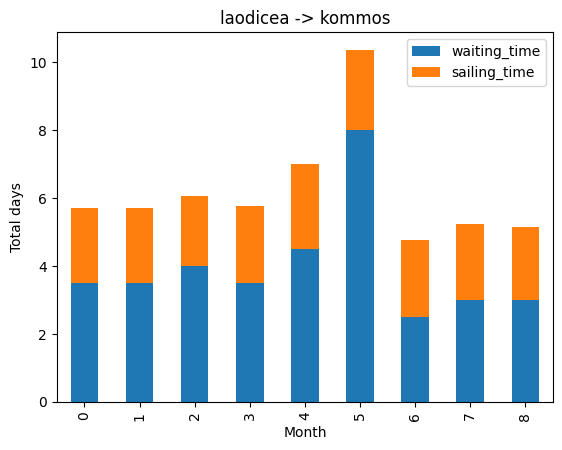

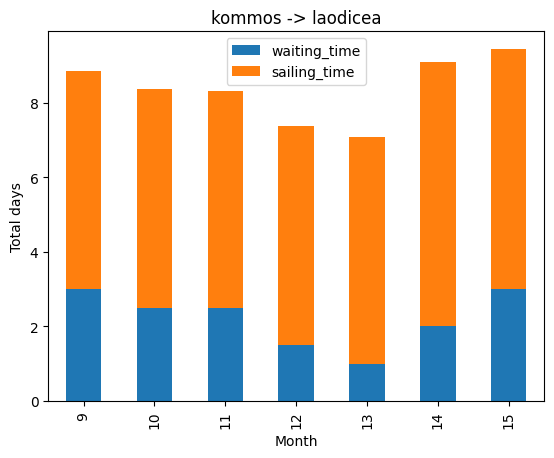

,month,origin,dest,path,waiting_time,sailing_time,total_time
55,Jan,tyre,ashkelon,"['tyre', 'ashkelon']",3.5,1.7,5.2
39,Jan,tyre,laodicea,"['tyre', 'laodicea']",2.0,1.6,3.6
66,Jan,tyre,kition,"['tyre', 'kition']",1.5,2.0,3.5
56,Feb,tyre,ashkelon,"['tyre', 'ashkelon']",3.5,1.6,5.1
40,Feb,tyre,laodicea,"['tyre', 'laodicea']",2.5,1.7,4.2
67,Feb,tyre,kition,"['tyre', 'kition']",2.0,2.1,4.1
68,Mar,tyre,kition,"['tyre', 'kition']",1.5,2.2,3.7
41,Mar,tyre,laodicea,"['tyre', 'laodicea']",2.0,1.6,3.6
57,Mar,tyre,ashkelon,"['tyre', 'ashkelon']",2.0,1.5,3.5
42,Apr,tyre,laodicea,"['tyre', 'laodicea']",2.5,1.7,4.2


In [55]:
valid_paths_summer_tyre,valid_destinations_tyre = generaete_map_all_bidirectional_paths_from_point("tyre", graph, "mobility_from_tyre")
styled = generate_colored_table_view_valid_paths(list(valid_destinations_tyre), valid_paths_summer_tyre, 3,fill_unknown=False)
styled